## Obligatorio

In [14]:
#!pip install wandb

     |████████████████████████████████| 2.1 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 209 kB 77.9 MB/s eta 0:00:01
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8785 sha256=327b2b081aab643719d980003bd9f5521b0a45de66cc8bd4b801f1b9c98ab011
  Stored in directory: /home/azureuser/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools


In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from collections import Counter

SyntaxError: invalid syntax (3398781608.py, line 8)

In [15]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /home/azureuser/.netrc


True

In [20]:
import random
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
connection_string = "DefaultEndpointsProtocol=https;AccountName=lucianagerman4638471639;AccountKey=s3ctA9+X+SqyzvUbgzESug9elvK5YbHEKD7Px4RuFu5SG/34BuO5zl+AkbffpYG1q8J+LSbjnpqp+AStfiXepA==;EndpointSuffix=core.windows.net"
container_name = "azureml-blobstore-712d0730-8ebc-42ee-99e3-a783cdcdbbff"

blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [3]:
blob_list = container_client.list_blobs() 

def load_image(blob):

    blob_client = blob_service_client.get_blob_client(container_name, blob.name)
    blob_data = blob_client.download_blob().readall()
    image = tf.image.decode_image(blob_data)
    image = tf.image.resize(image, (32, 32)) 
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    label = blob.name.split("_")[1].split(".")[0]
    return image, label

images = []

for blob in [blob for blob in blob_list if blob.name.startswith('images')]:
        image, label = load_image(blob)
        images.append((image, label))
    
images = np.array(images)


2023-07-01 00:34:00.523337: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-01 00:34:02.756093: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2023-07-01 00:34:03.124005: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-07-01 00:34:06.456207: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-01 00:34:08.272922: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2023-07-01 00:34:09.223582: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2023-

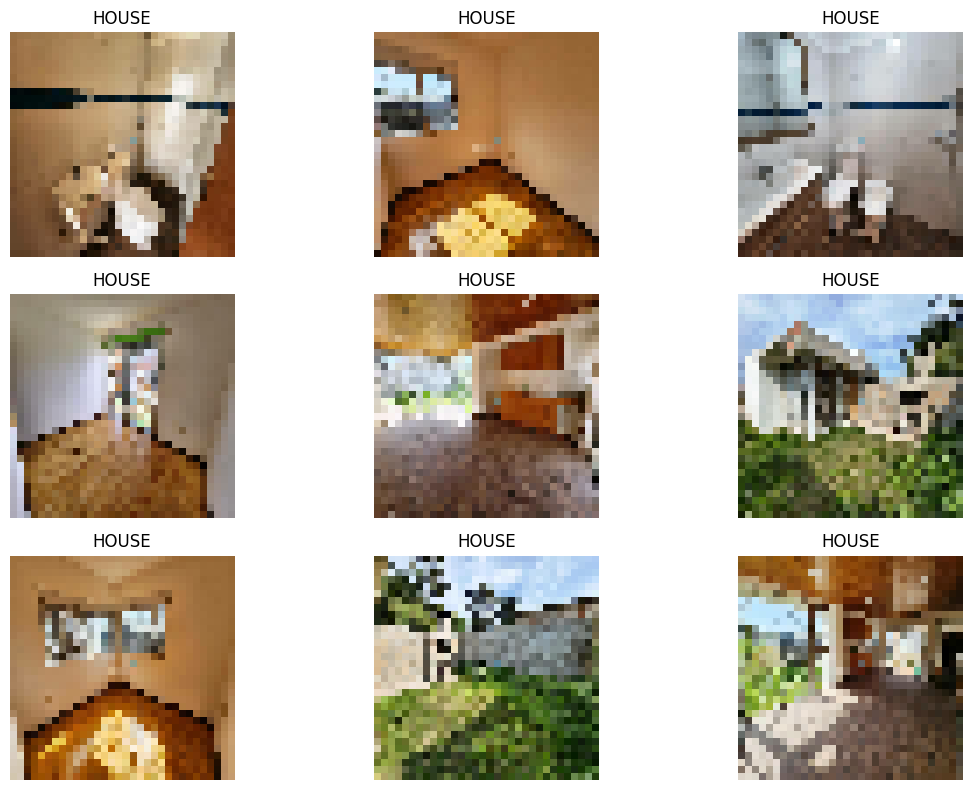

In [4]:
# Función para visualizar imágenes de muestra y sus etiquetas
def plot_sample_images(x, y):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(np.clip(x[i], 0, 1))
        plt.title(y[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar imágenes de muestra y sus etiquetas
plot_sample_images([tupla[0] for tupla in images], [tupla[1] for tupla in images])

In [10]:
# Dividir el objeto Dataset en conjuntos de entrenamiento y prueba
images_train, images_test = train_test_split(images, test_size=0.2, random_state=42)

x_train=np.array([image[0] for image in images_train])
y_train=np.array([label[1] for label in images_train])

x_test=np.array([image[0] for image in images_test])
y_test=np.array([label[1] for label in images_test])

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train)
y_test = binarizer.fit_transform(y_test)

# Convertir las etiquetas en one-hot
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)


In [22]:
Counter([label[1] for label in images_train])

Counter({'HOUSE': 76})

In [ ]:
# Launch 2 experiments, trying different dropout rates
for run in range(2):
    
    # Start a run, tracking hyperparameters
    wandb.init(
        project="ml-in-prod",
        config={
        
            "activation_1": "relu",
            "dropout": random.uniform(0.2, 0.5),
            "optimizer": "adam",
            "loss": "binary_crossentropy",
            "metric": "accuracy",
            "epoch": 100,
            "batch_size": 128,
        },
    )
    config = wandb.config
    
    # Define tu modelo
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32,32,3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(config.dropout),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(config.dropout),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    # Compila y entrena el modelo
    model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[config.metric])

    # Add WandbMetricsLogger to log metrics and WandbModelCheckpoint to log model checkpoints

    wandb_callbacks = [
        WandbMetricsLogger(),
        ModelCheckpoint(filepath="my_model_{epoch:02d}"),
    ]

    history = model.fit(x_train, y_train, batch_size=config.batch_size, epochs=config.epoch, validation_data=(x_test, y_test), callbacks=wandb_callbacks)
    
    wandb.finish()


Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.9719 - accuracy: 0.4342

2023-07-01 02:12:28.089265: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model_01/assets
1/1 [==============================] - 4s 4s/step - loss: 0.9719 - accuracy: 0.4342 - val_loss: 0.7197 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.9565 - accuracy: 0.5000 - val_loss: 0.7084 - val_accuracy: 0.1000
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 1.0176 - accuracy: 0.5263 - val_loss: 0.6918 - val_accuracy: 0.4500
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 0.9571 - accuracy: 0.5263 - val_loss: 0.6813 - val_accuracy: 0.9500
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.9920 - accuracy: 0.4868 - val_loss: 0.6731 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.9895 - accuracy: 0.5263 - val_loss: 0.6673 - val_accuracy: 1.0000
Epoch 7/100
1/1 [============================

In [ ]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Training')
    plt.plot(history_df['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Training')
    plt.plot(history_df['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig('training_validation_plots.png')
    plt.show()

# Call the plotting function to display the graphs
plot_history(history)

# Save the trained model
model.save('conv.h5')